<a href="https://colab.research.google.com/github/turnerluke/digit_recog/blob/main/LeNet_5_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

import itertools
import pickle

# Unpack, Preproess Data

In [96]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [97]:
print(f"Numer of training examples: {X_train.shape[0]}")
print(f"Numer of testing examples: {X_test.shape[0]}")

Numer of training examples: 60000
Numer of testing examples: 10000


#### Reshape to (n, 28, 28, 1)

In [98]:
# Reshape to (num_points, 28, 28, 1)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train.shape

(60000, 28, 28, 1)

In [99]:
# We won't create a validation set, since we have a labelled test set
'''from sklearn.model_selection import train_test_split
# Split X_train into Training & Validation sets
val_size = 0.05
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)

print(X_train.shape)
print(X_val.shape)'''


'from sklearn.model_selection import train_test_split\n# Split X_train into Training & Validation sets\nval_size = 0.05\nX_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)\n\nprint(X_train.shape)\nprint(X_val.shape)'

#### Standardize the images

In [100]:
example_idx = 4
X_ex_before = X_train[example_idx]

Xs = [X_train, X_test]

for i, X in enumerate(Xs):
  # Padding the images by 2 pixels since in the paper input images were 32x32
  X = np.pad(X, ((0,0),(2,2),(2,2),(0,0)), 'constant')
  
  # Standardize
  X_mean = X.mean().astype(np.float32)
  X_std = X.std().astype(np.float32)
  X = (X - X_mean) / X_std

  Xs[i] = X


X_train, X_test = Xs

X_ex_after = X_train[example_idx]
print(X_train.shape)
print(X_test.shape)

(60000, 32, 32, 1)
(10000, 32, 32, 1)


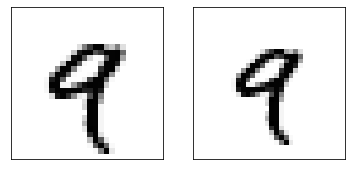

In [102]:
# Visualize the standardization
fig, axs = plt.subplots(1, 2)
axs[0].imshow(X_ex_before[:, :, 0], cmap='Greys')
axs[1].imshow(X_ex_after[:, :, 0], cmap='Greys')

axs[0].axes.xaxis.set_visible(False)
axs[0].axes.yaxis.set_visible(False)

axs[1].axes.xaxis.set_visible(False)
axs[1].axes.yaxis.set_visible(False)

plt.show()

#### One-hot encode the labels

In [104]:
from tensorflow.keras.utils import to_categorical

ys = [y_train, y_test]

for i, y in enumerate(ys):
  y = to_categorical(y, num_classes=10)
  ys[i] = y


y_train, y_test = ys

# LeNet-5 v2 Model Creation

In [106]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2

def LeNet5v2(input_shape = (32, 32, 1), classes = 10):
    """
    Implementation of a modified LeNet-5.
    Only those layers with learnable parameters are counted in the layer numbering.
    
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    model = Sequential([
        
    # Layer 1
    Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=l2(0.0005), name = 'convolution_1'),
    
    # Layer 2
    Conv2D(filters = 32, kernel_size = 5, strides = 1, name = 'convolution_2', use_bias=False),
    
    # Layer 3    
    BatchNormalization(name = 'batchnorm_1'),
        
    # -------------------------------- #  
    Activation("relu"),
    MaxPooling2D(pool_size = 2, strides = 2, name = 'max_pool_1'),
    Dropout(0.25, name = 'dropout_1'),
    # -------------------------------- #  
        
    # Layer 3
    Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005), name = 'convolution_3'),
        
    # Layer 4
    Conv2D(filters = 64, kernel_size = 3, strides = 1, name = 'convolution_4', use_bias=False),
        
    # Layer 5
    BatchNormalization(name = 'batchnorm_2'),
        
    # -------------------------------- #  
    Activation("relu"),
    MaxPooling2D(pool_size = 2, strides = 2, name = 'max_pool_2'),
        Dropout(0.25, name = 'dropout_2'),
    Flatten(name = 'flatten'),
    # -------------------------------- #  
        
    # Layer 6
    Dense(units = 256, name = 'fully_connected_1', use_bias=False),
        
    # Layer 7
    BatchNormalization(name = 'batchnorm_3'),
    
    # -------------------------------- #  
    Activation("relu"),
    # -------------------------------- #  
        
    # Layer 8
    Dense(units = 128, name = 'fully_connected_2', use_bias=False),
        
    # Layer 9
    BatchNormalization(name = 'batchnorm_4'),
        
    # -------------------------------- #  
    Activation("relu"),
    # -------------------------------- #  
        
    # Layer 10
    Dense(units = 84, name = 'fully_connected_3', use_bias=False),
        
    # Layer 11
    BatchNormalization(name = 'batchnorm_5'),
        
    # -------------------------------- #  
    Activation("relu"),
    Dropout(0.25, name = 'dropout_3'),
    # -------------------------------- #  

    # Output
    Dense(units = 10, activation = 'softmax', name = 'output')
        
    ])
    
    model._name = 'LeNet5v2'

    return model

#### Image Data Generator
Improves the dataset by performing the following operations randomly to the X data:
- Rotates 10 degress
- Zooms 10%
- Shifts images 10%

In [105]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# "Generate" new data w/ image generator

datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip = False)  # randomly flip images

datagen.fit(X_train)


#### Compile the model

In [107]:
le_net5_v2 = LeNet5v2()
le_net5_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
le_net5_v2.summary()


Model: "LeNet5v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolution_1 (Conv2D)      (None, 28, 28, 32)        832       
                                                                 
 convolution_2 (Conv2D)      (None, 24, 24, 32)        25600     
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 24, 24, 32)       128       
 tion)                                                           
                                                                 
 activation_25 (Activation)  (None, 24, 24, 32)        0         
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 12, 12, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)        0         
                                                          

#### Train the Model

In [108]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 2)

In [110]:
history = le_net5_v2.fit(datagen.flow(X_train, y_train, batch_size = 64),
                                   epochs = 30,
                                   callbacks = [variable_learning_rate],
                                   validation_data = (X_test, y_test))

Epoch 1/30
938/938 [==============================] - 317s 338ms/step - loss: 0.1912 - accuracy: 0.9504 - val_loss: 0.0691 - val_accuracy: 0.9845 - lr: 0.0010
Epoch 2/30
938/938 [==============================] - 321s 342ms/step - loss: 0.1213 - accuracy: 0.9695 - val_loss: 0.0585 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 3/30
938/938 [==============================] - 322s 344ms/step - loss: 0.1002 - accuracy: 0.9750 - val_loss: 0.0396 - val_accuracy: 0.9915 - lr: 0.0010
Epoch 4/30
938/938 [==============================] - 346s 369ms/step - loss: 0.0866 - accuracy: 0.9789 - val_loss: 0.0743 - val_accuracy: 0.9803 - lr: 0.0010
Epoch 5/30
938/938 [==============================] - 314s 335ms/step - loss: 0.0797 - accuracy: 0.9799 - val_loss: 0.0480 - val_accuracy: 0.9894 - lr: 0.0010
Epoch 6/30
938/938 [==============================] - 312s 333ms/step - loss: 0.0582 - accuracy: 0.9868 - val_loss: 0.0271 - val_accuracy: 0.9947 - lr: 2.0000e-04
Epoch 7/30
938/938 [======================

#### Save the Model

In [112]:
le_net5_v2.save("le_net5_v2.h5")
# Pickle the training history data, so we don't have to re-train the model (~2.6hrs)
with open('history.pickle', 'wb') as f:
  pickle.dump(history, f)

INFO:tensorflow:Assets written to: ram://02aa945f-dd0d-403a-8e2e-10afe617b984/assets


# Visualize Results

#### Training Accuracy vs. Epoch

No handles with labels found to put in legend.


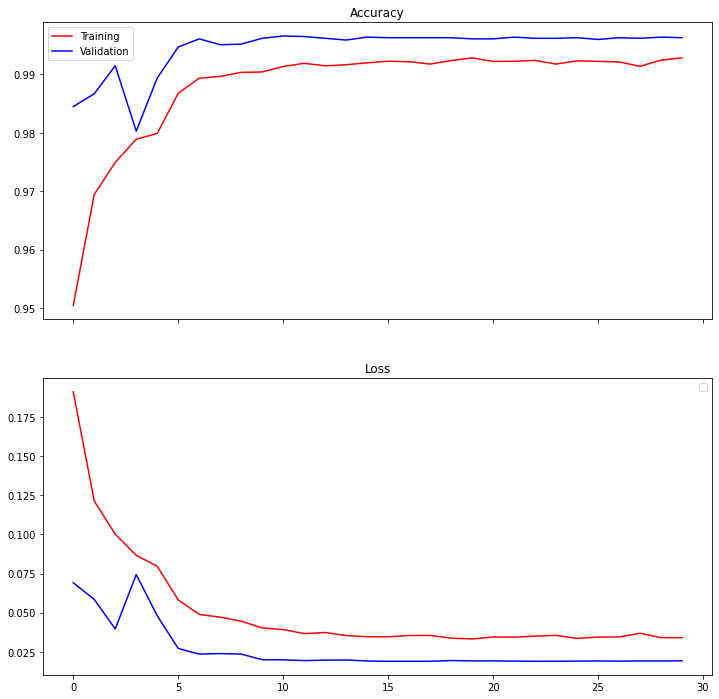

In [119]:

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 12))
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
axs[0].plot(epochs, acc, 'r')
axs[0].plot(epochs, val_acc, 'b')
axs[0].set_title('Accuracy')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
axs[1].plot(epochs, loss, 'r')
axs[1].plot(epochs, val_loss, 'b')
axs[1].set_title("Loss")
axs[1].legend(["Training", "Validation"], loc=1)

Notice that the model performs better on the validation set than the training. This is not an error. Since `Dropout` is being used less features are used during training, as opposed to all being used during testing.

#### Confusion Matrix

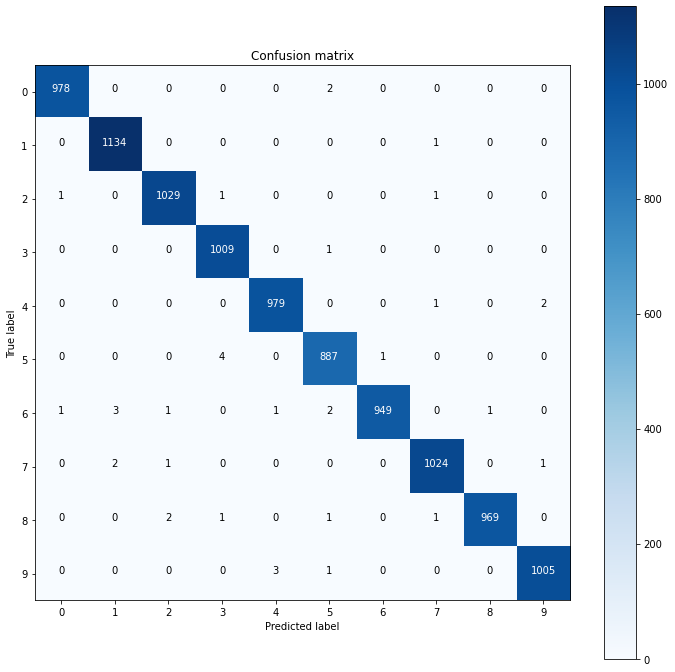

In [129]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    plt.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))

    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)

    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #ax.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = le_net5_v2.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

# Conclusion

#### Accuracy

In [138]:
acc = np.mean(y_pred_classes == y_true)

print(f"Final accuracy on test set: {round(acc*100, 2)}%")

Final accuracy on test set: 99.63 %


An accuracy of 99.63% is quite good on the MNIST dataset.

The next aspect of this project will be to deploy this model to a Flask web app, allowing the user to draw a digit to be predicted.

Follow the project here:

[![View on GitHub](https://img.shields.io/badge/GitHub-View_on_GitHub-blue?logo=GitHub)](https://github.com/turnerluke/digit_recog
)